<h1><center><b>Binary classification - IMA 205</b></center></h1>
<h3><center>Brayam Velandia</center></h3>

_____
In this report, we are gonna explain the process of Binary Classification for images obtained with the Papanicolaou test. This is a method of cervical screening used to detect potentially precancerous and cancerous processes. In this part we are gonna evaluate the binary problem, with the idea of detect the normal and abnormal cells. Nowadays, some laboratories implement manual screening, that allows big mistakes in the classification. This is why the implementation of Machine Learning algorithms for automated classification οf cell images is very important. 

First, we are gonna explain the Deep Learning methods implemented. Second, we are gonna descrive the feature extraction implemented in the dataset provided, the algorithms used for the binary classification and the pre- and post-processing methods. Finally, we are will compare the results obtained in order to select the best classification method.
______




# **Data Processing**

###**Importing the data**

Let us start by importing the databases of the cervical screening. The data classification will be obtained with the .csv file that allows us to know if the image correspond to a Normal or Abnormal cell.

In [1]:
from functions import graphhistory, predictImage, area_nuc, area_cyt, perim_nuc, perim_cyt, col_nuc, col_cyt, den_nuc, den_cyt, multipleimage, encode
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google_drive_downloader import GoogleDriveDownloader as gdd
from skimage.io import imread
import pandas as pd
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6)      # setting default size of plots
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
#from sklearn.cross_validation import StratifiedShuffleSplit   # this was the old version
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier #AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from keras.layers import Input,Convolution2D, Dense, Activation, Flatten, merge, Conv2D
from keras.layers import MaxPooling2D, Dropout, LocallyConnected2D, MaxPool2D, MaxPool1D
from keras.models import Model, load_model,  Sequential
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
gdd.download_file_from_google_drive(file_id='1-iFMVq5Mo63YaG3PTiXRswwwerKxQSQw',
dest_path='./data/metadataTrain.csv')

gdd.download_file_from_google_drive(file_id='1oea2SOfhxj_VXoGWrDafijzwbvmN3MnP',
dest_path='./data/SampleSubmission.csv')

gdd.download_file_from_google_drive(file_id='1fE2Q8OxhVB9-Y1GPdrNit1nj8DaUgQMX',
                                    dest_path='./data/Test.zip',
                                    unzip=True)

gdd.download_file_from_google_drive(file_id='1aJLdWrD5WjtTAuHdfc6hzEj5G2gCVT7r',
                                    dest_path='./data/Train.zip',
                                    unzip=True)

Unzipping...Done.
Unzipping...Done.


Now, let us create the dataframes thet allow us to classify the images in the Train folder.

In [3]:
train = []
ID = []
for filenames in os.listdir('/content/data/Train'):
    if '_' not in filenames:
        train.append(imread(os.path.join('/content/data/Train',filenames)))
        ID.append(int(filenames.split('.')[0]))
    
labels = pd.read_csv('/content/data/metadataTrain.csv')


In this part, we will work with the two dataframes Abnormal (A boolean feature) and ID. For this, we create two numpy arrays with this information.

In [4]:
#Dataframes
normal=labels["ABNORMAL"]
id=labels["ID"]
classes=labels["GROUP"]
#Numpy arrays
normal=normal.to_numpy()
id=id.to_numpy()
classes=classes.to_numpy()

#**Deep Learning Implementation**

###**Data pre-processing**

Through the effective use of Neural Networks (Deep Learning Models), binary classification problems can be solved to a fairly high degree. Since the Newral Network methods allow us to classify the images without the feature extraction. We are going to start by implementing this method. We start by creating two folders "NORMAL" and "ABNORMAL". In this way, we will preparate our data in a desirable way for the Neural Network implementation.

In [5]:
!mkdir TrainData
!mkdir /content/TrainData/ABNORMAL
!mkdir /content/TrainData/NORMAL

import shutil
for i in range(len(normal)):
  if normal[i]==0:
    im_id=str(id[i])
    shutil.move("/content/data/Train/"+im_id+".bmp", "/content/TrainData/NORMAL")

  if normal[i]==1:
    im_id=str(id[i])
    shutil.move("/content/data/Train/"+im_id+".bmp", "/content/TrainData/ABNORMAL")

Now we are going to generate the data to use in the model. For this, we are going to separate our dataset into train and validation dataset. For this porpuse we are going to use Image Data Generator from Keras.

Keras provides the ImageDataGenerator class that defines the configuration for image data preparation and augmentation. The generator will progressively load the images in the dataset, allowing us to work with both small and very large datasets containing thousands or millions of images that may not fit into system memory.

In [6]:
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)                                          


train_dataset = image_generator.flow_from_directory("/content/TrainData",batch_size=32,
                                                 target_size=(150, 150), 
                                                 subset='training',
                                                 class_mode='binary')

validation_dataset = image_generator.flow_from_directory("/content/TrainData",batch_size=32,
                                                 target_size=(150, 150),
                                                 subset='validation',
                                                 class_mode='binary')

Found 2338 images belonging to 2 classes.
Found 583 images belonging to 2 classes.


Now, we see that we have succesfully divided our data in the train dataset with 2338 images and the validation dataset with 583 images. The corresponding class indices assigned to each class are the following.

In [7]:
validation_dataset.class_indices

{'ABNORMAL': 0, 'NORMAL': 1}

_____________
###**ANN Implementation**

Here we continue with the definition of the model. We implement a Sequential Network with the folowing characteristics.



*   Convolutional layer and maxpool layer 1 with Relu activation (32)
*   Convolutional layer and maxpool layer 2 with Relu activation (64)
*   Convolutional layer and maxpool layer 3 with Relu activation (128)
*   Convolutional layer and maxpool layer 3 with Relu activation (128)
*   Flattens layer - the resulting image array to 1D array
*   Hidden layer with 512 neurons and Rectified Linear Unit activation function 
*   Output layer with single neuron, the activation function is a Sigmoid in order to obtain 0 or 1 for a binary classification problem




In [8]:
model = keras.Sequential()

# Convolutional layer and maxpool layer 1
model.add(keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 2
model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 3
model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 4
model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# This layer flattens the resulting image array to 1D array
model.add(keras.layers.Flatten())

# Hidden layer with 512 neurons and Rectified Linear Unit activation function 
model.add(keras.layers.Dense(512,activation='relu'))

# Output layer with single neuron which gives 0 
#Here we use sigmoid activation function which makes our model output to lie between 0 and 1
model.add(keras.layers.Dense(1,activation='sigmoid'))

After we define the network, we compile the model, for this we need to define the following:



1.   **Optimizer:** We choose Adam, since is one of the most recommended for his Adaptative Gradient Algorithm and the Root mean square propagation. This characteristics maintain a per-parameter learning rate that improves performance on problens with sparce gradients.
2.   **Loss:**  Since this is a Binary classification problem. The best option is to implement binary crossentropy.
3.   **Metrics:** For this time, we just calculate the accuracy. It is the ratio of number of correct predictions to the total number of input samples.


In [9]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history=model.fit_generator(train_dataset,
         steps_per_epoch = 73,
         epochs = 20,
         validation_data = validation_dataset
         )

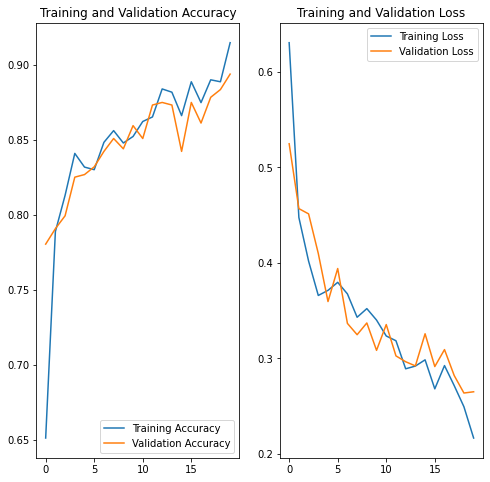

In [14]:
graphhistory(history)

Here we obtain an accuracy of **89.37** on the validation dataset and Loss **0.2651**. This is a good result if we compare with the model performance in the classic methods in the last part. However, we will use some other techniques that can improve this result as Convolutional Neural Networks or Data Augmentation.

______
### **CNN Implementation**

In order to improve our results, we are going to test the transfer learning techniques. This is a neural network model, first trained on a problem similar to the problem that is being solved. Transfer learning has the advantage of decreasing the training time for a learning model and can result in lower generalization error. 

In [8]:
RANDOM_SEED = 1 # Here we define some parameters of the image
IMG_SIZE = (150, 150) # size of vgg16 input
IMG_PATH = "/content/TrainData"

For this porpuse, we will implement VGGNet. This is a Deep Convolutional Neural Network that was proposed by Karen Simonyan and Andrew Zisserman of the University of Oxford. As this convolutional neural network has 16 layers in its architecture, it was named VGG-16. This model was proposed to reduce the number of parameters in a convolutional neural network with improved training time.

The idea is to add the model to our model, and ignore the Top Layer. In order to use our own output layer. In this case a layer with 2 classes or 9 in the multicalssification.

In [ ]:
vgg16_weight_path = '../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

base_model = tf.keras.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)


model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.layers[0].trainable = False


model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model.summary()

In [ ]:
EPOCHS = 20
history=model.fit_generator(train_dataset,
         steps_per_epoch = 73,
         epochs = 20,
         validation_data = validation_dataset
         )

print("Training Done")
model.save("model.h5")

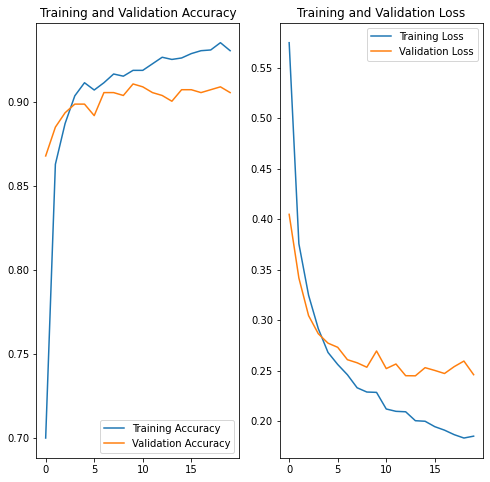

In [13]:
graphhistory(history)

As we can see by classifying the cervical screening in 2 classes, the model has given a **minimum accuracy of 86%** and a **maximum accuracy of 91%**. We can further tune the training parameters and re-train our model to see any possible upscaling in the classification. But what we have got in this experiment is the standard one. We will discuss this results in the conlusions.

_____
### **Test the model**

Now we are gonna test the model with the dataset destinated for the challenge, for this we are gonna use the function predictImage that implement the model with the input image.

The Test folder contains the original cervical screening and the segmentation. However, we just need the original image to classify it as Abnormal or Normal. For this, we ignore all the files with the character "_" in the path.

In [21]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir("/content/data/Test") if isfile(join("/content/data/Test", f))]
onlyfiles
files=[]

for file in onlyfiles:
  if '_' not in file:
    files.append(file)

Now, we create two arrays: Id_test tht will save the Id of each image and predict_test with the respective prediction. We do this, in order to be sure that the result will correspond to the Sample Submission order.

In [ ]:
import csv
Id_test = []
predict_test=[]

with open('/content/data/SampleSubmission.csv', 'r') as csvfile:
  filereader = csv.reader(csvfile, delimiter=',')
  for row in filereader:
    Id_test.append(row[0])
    predict_test.append(row[1])

Id_paths=[]
for id in Id_test:
  new_id=id+".bmp"
  Id_paths.append(new_id)

Finally, we compute the prediction for each image and we write this information in our .csv file.

In [ ]:
prediction=[]
for image_cell in Id_paths:
  if image_cell != "ID.bmp":
      path=str("/content/data/Test/"+image_cell)
      value=predictImage(path)
      prediction.append(int(value > .5))
  print(image_cell,value)

  for value in prediction: # Convert values diferent to 0 or 1
  if value<0.5:
    value="0"
  else:
    value="1"


In [ ]:
with open('/content/data/SampleSubmission.csv', 'w') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)      
    write.writerow(final_prediction)

# **Feature extraction**

After we implemented some Deep Learning Methods. We are goning to use the classical methods we saw in the course. For this porpuse, we need to create a dataset with the images we already have that describes some characteristics. We call this process Feature extraction.

Our interest is to evaluate some of the characteristics of the cervical screening. In this case:

*   Nucleus area
*   Cytoplasm area
*   Nucleus perimeter
*   Cytoplasm perimeter
*   Nucleus color
*   Cytoplasm color
*   Nucleus density
*   Cytoplasm density


Now, we are gonna test this results in a random example, in order to understand what information will show our algorithm. But first, let us create a folder with the respective images segmentation of the cell.



In [14]:
!mkdir Feature
!mkdir /content/Feature/Nuc
!mkdir /content/Feature/Cyt

In [7]:
import shutil
for i in range(len(normal)):
  im_id=str(id[i])
  shutil.move("/content/data/Train/"+im_id+"_segCyt.bmp", "/content/Feature/Cyt")
  shutil.move("/content/data/Train/"+im_id+"_segNuc.bmp", "/content/Feature/Nuc")

Now that we have moved all the images, we can test our feature extraction functions.

In [8]:
from skimage.io import imread, imshow
imagenuc = imread("/content/Feature/Nuc/1095_segNuc.bmp", as_gray=True)
imagecyt = imread("/content/Feature/Cyt/1095_segCyt.bmp", as_gray=True)
imagecol= imread("/content/data/Train/1095.bmp", as_gray=False)


Here we can see that for the image 1095 we have displayed our 8 features. In order to understand more what this features mean. Let us see the last ones, the color of the nucleus and the cytoplasma and the density. 

In [28]:
features= area_nuc(imagenuc), area_cyt(imagecyt),perim_nuc(imagenuc), perim_cyt(imagecyt), col_nuc(imagecol, imagenuc), col_cyt(imagecol, imagecyt), den_nuc(imagecol, imagenuc), den_cyt(imagecol, imagecyt)
features

(12701.0, 7286.0, 216, 890, 381026.31, 1701700.579, 211260.108, 1058797.143)

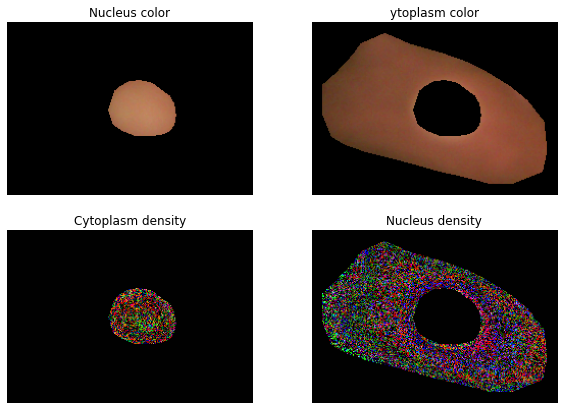

In [61]:
multipleimage(imagenuc,imagecyt,imagecol)

We need to extract all the features for all the images. For this, we are gonna create a list with the id of the images and the respectives features.

In [9]:
features=[]
for cell in id:
  cell_features=[]
  imagenuc = imread("/content/Feature/Nuc/"+str(cell)+"_segNuc.bmp", as_gray=True)
  imagecyt = imread("/content/Feature/Cyt/"+str(cell)+"_segCyt.bmp", as_gray=True)
  imagecol= imread("/content/data/Train/"+str(cell)+".bmp", as_gray=False)

  cell_features.append(cell)
  cell_features.append(area_nuc(imagenuc))
  cell_features.append(area_cyt(imagecyt))
  cell_features.append(perim_nuc(imagenuc))
  cell_features.append(perim_cyt(imagecyt))
  cell_features.append(col_nuc(imagecol, imagenuc))
  cell_features.append(col_cyt(imagecol, imagecyt))
  cell_features.append(den_nuc(imagecol, imagenuc))
  cell_features.append(den_cyt(imagecol, imagecyt))
  features.append(cell_features)

Finally, we extract all the features in a .csv file in order to use it in the multiclass selection.

In [25]:
outfile = open('/content/Features.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], features))
outfile.close()

#**Classical Methods**

With the same idea, we are going to use some of the classic methods usually used to classify the images. We will show below the solution of each question of the ML methodology (representation, optimization, model selection) and model evaluation. At this point, we assume that our feature extraction was correctly implemented.

###**Explore the dataset**

______

We start uploading the dataset, before it is necesary to add the names of each dataframe in order to analize the dataset correctly. At this point we have 8 dataframes with the features of the cervical screening.
______


In [17]:
def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn

In [18]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='11Q-bIEQCTwXAmQj6yxo47B2jr9YioGF6',
                                    dest_path='/content/data/features.csv')

gdd.download_file_from_google_drive(file_id='1IGgzD14yuAUFPnBcz5cPlDBjsbCj_zZm',
                                    dest_path='/content/data/features_test.csv')

In [19]:
train_df = pd.read_csv("/content/data/features.csv")


____
Here we can take a look to the final dataset. We have the ID, if the image is normal or abnormal, the group and the features.
____

In [20]:
train_df.head(10)

,ID,ABNORMAL,GROUP,F1,F2,F3,F4,F5,F6,F7,F8
0,4289,1,7,8497.666667,6034.000000,269,809,827797.209,1615178.724,396447.353,849407.094
1,1810,1,8,10179.333333,8456.000000,308,919,962330.408,1351416.415,409455.086,745399.673
2,1906,1,8,4429.000000,2496.333333,103,444,90662.844,605080.851,61153.414,406308.405
3,3944,0,1,16930.333333,8125.333333,244,994,637671.998,4490930.949,330108.710,2203489.213
4,1597,1,7,4666.666667,3020.666667,176,527,258868.907,604800.378,146287.787,339732.798
5,1278,1,3,1385.666667,2201.333333,305,547,459042.510,81491.990,4157.000,6677.438
6,1715,1,5,1756.000000,2387.666667,299,376,791303.950,235916.442,5268.000,7163.000
7,3020,0,1,11812.666667,7002.000000,241,949,567107.524,2271326.372,323352.684,1144042.950
8,1115,0,0,55520.666667,24253.333333,149,1443,228211.875,7504206.609,278846.233,5250446.545
9,3107,0,0,17737.666667,8796.000000,135,931,204259.436,2007874.964,53213.000,27709.074


_____
It is important to evaluate how many samples have each class in order to see if we are working with a balanced or unbalanced dataset. Here we can see that the difference between Normal and Abnormal is not significative. 
_____

In [21]:
train_df["ABNORMAL"].value_counts()[:]

1    1109
0     938
Name: ABNORMAL, dtype: int64

In [22]:
train_df.shape

(2047, 11)

In [ ]:
train_df.info()

In [24]:
test_df = pd.read_csv("/content/data/features_test.csv")

In [25]:
test_df.head()

,ID,ABNORMAL,GROUP,F1,F2,F3,F4,F5,F6,F7,F8
0,1721,1,8,13240.000000,12420.666667,311,1039,664865.509,999638.337,289859.901,436045.643
1,311,0,1,11191.000000,6905.666667,263,827,589913.325,1754699.401,325767.967,984093.049
2,1502,1,7,4756.000000,3110.000000,138,481,238814.132,595099.573,125480.734,333446.991
3,4227,0,1,4553.000000,3257.333333,185,551,272089.636,525695.560,158628.770,358861.372
4,3604,1,7,3259.333333,2613.333333,168,472,373028.060,652240.510,134914.862,287363.686


In [26]:
test_df.shape

(874, 11)

In [ ]:
test_df.info()

_____

###**Exploratory data analysis**

In order to evaluate the best solution, we need to representate some of the variables we are gonna use in our model. For that, we are gonna implement the EDA, this is an approach of analyzing data sets to summarize their main characteristics, often using statistical graphics and other data visualization methods. The idea is to  see what the data can tell us beyond the formal modeling or hypothesis testing task. 
_____


**Feature 1 - Nucleus area**:

Let us take a look to the Nucleus area. We can constate that the ABNORMAL has a higuer nuclus area  than the class NORMAL class. This is how the model will take into account these examples in order to classify the input.

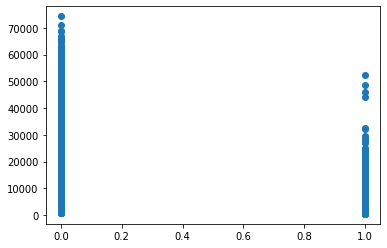

In [40]:
_ = plt.scatter(train_df["ABNORMAL"], train_df["F1"])

**Feature 5 - Nucleus Color**:

Instead the nucelus color has higuer values in the NORMAL class than in the ABNORMAL class. This could be a discriminant factor for our model.

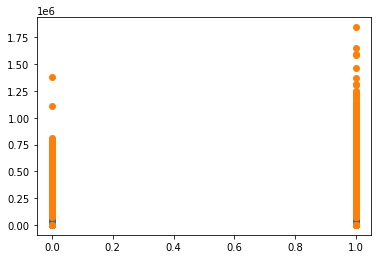

In [39]:
_ = plt.scatter(train_df["ABNORMAL"], train_df["F5"])


_____
###**Distribution after scaling**

Machine learning algorithm just sees numbers. If there is a vast difference in the range say few ranging in thousands and few ranging in the tens, and it makes the underlying assumption that higher ranging numbers have superiority of some sort. So these more significant number starts playing a more decisive role while training the model. For this reason it is important to scale the data before the train.
______

In [29]:
train_df, labels, test_df, test_ids, classes = encode(train_df, test_df)
train_df.head()

,F1,F2,F3,F4,F5,F6,F7,F8
0,8497.666667,6034.000000,269,809,827797.209,1615178.724,396447.353,849407.094
1,10179.333333,8456.000000,308,919,962330.408,1351416.415,409455.086,745399.673
2,4429.000000,2496.333333,103,444,90662.844,605080.851,61153.414,406308.405
3,16930.333333,8125.333333,244,994,637671.998,4490930.949,330108.710,2203489.213
4,4666.666667,3020.666667,176,527,258868.907,604800.378,146287.787,339732.798


In [30]:
X = train_df.values
y = labels

In [31]:
sss = StratifiedShuffleSplit(test_size = 0.2, random_state= 8)
sss.get_n_splits(X, y)

10

In [32]:
for train_index, test_index in sss.split(X,y):
    X_train, X_test = X[train_index],X[test_index]
    y_train, y_test = y[train_index],y[test_index]

In [33]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(np.sqrt(X_train))
scaled_test_data = scaler.transform(np.sqrt(X_test))

_______
### **Distribution of the raw data and division Train - Test**
Now, in order to assure that our model will be trained and tested in good conditions. We check that the distribution of the raw data is similar between train and test datasets. The histograms we show below are donne after the scaling of the data.
_________

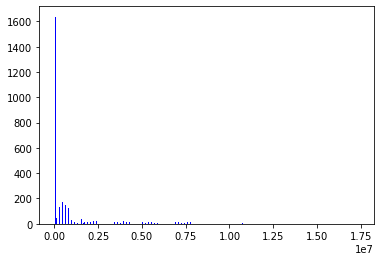

In [56]:
_ = plt.hist(X_train,bins= 100,facecolor='blue')

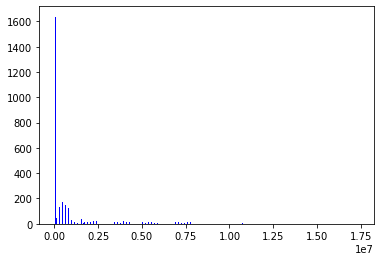

In [57]:
_ = plt.hist(X_train, bins = 100, facecolor= "blue")

##**Select and test models**

#### **Raw data**

____
First, we are gonna implement four of the algorithms we already used in class. KNeighbors, Random Forest and Gaussian NB. We are going to test the accuracy and log_loss with raw data. Then we will apply some optimization methods in order to improve our results.
____

In [34]:
classifiers_exp = [
    KNeighborsClassifier(3,n_jobs= -1),
    RandomForestClassifier(),
    GaussianNB(),
    LogisticRegression()]

log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers_exp:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    

    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 84.3902%
Log Loss: 2.18830007685627
RandomForestClassifier
****Results****
Accuracy: 87.5610%
Log Loss: 0.3025907104180042
GaussianNB
****Results****
Accuracy: 81.4634%
Log Loss: 1.417736664574031
LogisticRegression
****Results****
Accuracy: 82.6829%
Log Loss: 0.39042331087810705


_____
Here we can see that the Random Forest show the best perfonce with an accuracy of 87.56% and Logistic Loss 0.3025 by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes. Instead, Gaussian NB show a lower accuracy with 81.46%, and K NeighBors Classfier has the higuer loss with 2.1883. It is important to say that this is the raw data, that means that our result could be improved with data pre-processing and optimization methods as we will see below.
______

### **Deskewing**

Deskewing is a process whereby skew is removed by rotating an image by the same amount as its skew but in the opposite direction. However, we can apply this same logic in order to optimize our models. Since some the covariates of the classes are well defined. We can use this like a reference and approximate other covariates in order to approach to an specific class.

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin
class Deskew(BaseEstimator, TransformerMixin):
    def __init__ (self,alpha=1):
        self.alpha = alpha
    def _reset(self):
        pass
    def fit(self,X,y):
        return self
    def transform(self,X):
        return np.log(X + self.alpha)
    def fit_transform(self,X,y):
        return self.transform(X)
    def inverse_transform(self, X):
        return np.exp(X) - self.alpha
    def score(self,X,y):
        pass

In [36]:
deskew = Deskew()

## **Logistic Regression**

Let us start with our first model, Logistic Regression. In the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme if the ‘multi_class’ option is set to ‘ovr’, and uses the cross-entropy loss if the ‘multi_class’ option is set to ‘multinomial’. In this case we set in auto, that selects ‘multi_class’ by default.

In [37]:
logreg_pipe = Pipeline([
    ("deskew", Deskew()),
    ("scaler" , StandardScaler()),
    ("logit", LogisticRegression(random_state=8,n_jobs= -1))
])

Pipeline only

In [ ]:
logreg_pipe.fit(X_train,y_train)

In [39]:
logreg_pipe.score(X_train,y_train)

0.7929138668295663

In [40]:
train_predictions = logreg_pipe.predict(X_test)
accuracy_logreg = accuracy_score(y_test, train_predictions)
accuracy_logreg

0.8195121951219512

In [41]:
train_predictions_logreg = logreg_pipe.predict_proba(X_test)
log_loss_logreg = log_loss(y_test, train_predictions_logreg)
log_loss_logreg

0.421485986589342

In [42]:
logreg_params = {
    "logit__max_iter" : [3,50],
    "logit__C" : np.logspace(-4,4,9)
}

###**Logreg after GridSearch**

Now we are gonna implement hyperparameter optimization.  With GridSearch we can start an exhaustive searching through a manually specified subset of the hyperparameter space of a learning algorithm. A grid search algorithm must be guided by some performance metric, typically measured by cross-validation on the training set or evaluation on a held-out validation set.

In [43]:
#GridSearch 
gs_logreg = GridSearchCV(logreg_pipe, param_grid=logreg_params,cv = 5, n_jobs= -1)

In [ ]:
#LogistticRegression GridSearch
gs_logreg.fit(X_train, y_train)

In [45]:
#LogistticRegression GridSearch
gs_train_pred1 = gs_logreg.predict(X_test)
accuracy_logreg_gs1 = accuracy_score(y_test, gs_train_pred1)
accuracy_logreg_gs1

0.8170731707317073

In [46]:
#LogisticRegression GridSearch Log_Loss
gs_train_pred_logreg = gs_logreg.predict_proba(X_test)
log_loss_logreg_gs = log_loss(y_test, gs_train_pred_logreg)
log_loss_logreg_gs

0.41953987313523666

##**Random Forest Classifier :**

Now, we change the ensemble learning method for the Random Forest. Basically, we want to predict by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean/average prediction (regression) of the individual trees.

In [47]:
rfc_pipe = Pipeline([
    ("deskew", Deskew()),
    ('scaler',StandardScaler()),
    ('clf', RandomForestClassifier(random_state=8))
])

Pipeline only

In [ ]:
rfc_pipe.fit(X_train, y_train)

In [49]:
rfc_pipe.score(X_train,y_train)

1.0

In [50]:
rfc_predictions = rfc_pipe.predict(X_test)
accuracy_rfc = accuracy_score(y_test, rfc_predictions)
accuracy_rfc

0.8829268292682927

In [51]:
rfc_predict_proba = rfc_pipe.predict_proba(X_test)
rfc_log_loss = log_loss(y_test, rfc_predict_proba)
rfc_log_loss

0.3822331559671298

In [52]:
rfc_params = {
    'clf__n_estimators':[10,50,100,200],
    'clf__max_features':['auto','log2']
}


### **Random Forest after GridSearch**

In [ ]:
#you might want to fit on this
rfc_gs = GridSearchCV(rfc_pipe, param_grid=rfc_params, cv=5,n_jobs=-1)
rfc_gs.fit(X_train,y_train)

In [54]:
rfc_pred_gs = rfc_gs.predict(X_test)
accuracy_rfc_gs = accuracy_score(y_test, rfc_pred_gs)
accuracy_rfc_gs

0.8707317073170732

In [55]:
rfc_predict_proba = rfc_gs.predict_proba(X_test)
rfc_log_loss = log_loss(y_test, rfc_predict_proba)
rfc_log_loss

0.2940035558091526

## **Naive Bayes Gaussian :**

Another supervised learning algorithm is Naive Bayes. Based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.

In [56]:
gnb_pipe = Pipeline([
    ("deskew", Deskew()),
    ('scaler',StandardScaler()),
    ('gnb', GaussianNB())
])

Pipeline only

In [ ]:
gnb_pipe.fit(X_train,y_train)

In [58]:
gnb_pipe.score(X_train,y_train)

0.7745876603543067

In [59]:
gnb_predictions = gnb_pipe.predict(X_test)
accuracy_gnb = accuracy_score(y_test, gnb_predictions)
accuracy_gnb

0.8

In [60]:
gnb_predict_proba = gnb_pipe.predict_proba(X_test)
gnb_log_loss = log_loss(y_test, gnb_predict_proba)
gnb_log_loss

1.0774144146228588

##**KNeighborsClassifier:**

Other approach, KNeighbors. The input consists of the k closest training examples in data set. The output is a class membership. A leaf is classified by a plurality vote of its neighbors, with the leaf being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the leaf is simply assigned to the class of that single nearest neighbor.

In [61]:
knc_pipe = Pipeline([
    ("deskew", Deskew()),
    ('scaler', StandardScaler()),
    ('knc',KNeighborsClassifier())
])

Pipeline only

In [ ]:
knc_pipe.fit(X_train,y_train)

In [63]:
knc_pipe.score(X_train,y_train)

0.8888210140500916

In [64]:
knc_predictions= knc_pipe.predict(X_test)
accuracy_knc = accuracy_score(y_test, knc_predictions)
accuracy_knc

0.8780487804878049

In [65]:
knc_predict_proba = knc_pipe.predict_proba(X_test)
knc_log_loss = log_loss(y_test,knc_predict_proba)
knc_log_loss

1.4527348135055551

In [66]:
#for GridSearch
knparams = {
    'knc__n_neighbors':range(1,15),
    "knc__weights" : ["distance","uniform"]
}

### **KNeighbors after GridSearch**

In [ ]:
kn_gs = GridSearchCV(knc_pipe, param_grid=knparams, cv=5,n_jobs=-1)
kn_gs.fit(X_train,y_train)

In [68]:
kn_gs.score(X_test, y_test)

0.8780487804878049

In [69]:
kn_gs_predictions= kn_gs.predict(X_test)
accuracy_kn_gs = accuracy_score(y_test, kn_gs_predictions)
accuracy_kn_gs

0.8780487804878049

In [70]:
kngs_predict_proba = kn_gs.predict_proba(X_test)
kngs_log_loss = log_loss(y_test,kngs_predict_proba)
kngs_log_loss

0.6625868086377703

###**Comment on results**

**Creating the Results DataFrame**

Let us start by creating a Dataset with all the results we have found.

In [86]:
pre_list =["raw data","raw data","raw data","raw data",
           "scaled","scaled","scaled","scaled",
           "deskewed_scaled","deskewed_scaled","deskewed_scaled","deskewed_scaled",
           "gridsearched","gridsearched","gridsearched"]

clf_list = ["KNeighbors","RandomForest","GaussianNB","LogisticReg",
           "KNeighbors","RandomForest","GaussianNB","LogisticReg",
           "KNeighbors","RandomForest","GaussianNB","LogisticReg",
           "KNeighbors","RandomForest","LogisticReg"]

acc_list = [0.8439, 0.8756, 0.8146, 0.8268,
           0.8888,0.8829,0.7745,0.7929,
           0.8780,0.8829,0.8,0.8195,
           0.8780,0.8707, 0.8170]

loss_list = [2.1883, 0.3025,1.4177,0.3904,
            1.4527,0.3822,1.07,0.4214,
            1.4527,0.3822,1.07,0.4214,
            0.6625,0.2940,0.4195]

In [87]:
log_df = pd.DataFrame(
    {'Preprocessing': pre_list,
     "Classifier": clf_list,
     'Accuracy': acc_list,
     "Log Loss" : loss_list
    },columns=['Preprocessing','Classifier', 'Accuracy',"Log Loss"])

In [88]:
log_df

,Preprocessing,Classifier,Accuracy,Log Loss
0,raw data,KNeighbors,0.8439,2.1883
1,raw data,RandomForest,0.8756,0.3025
2,raw data,GaussianNB,0.8146,1.4177
3,raw data,LogisticReg,0.8268,0.3904
4,scaled,KNeighbors,0.8888,1.4527
5,scaled,RandomForest,0.8829,0.3822
6,scaled,GaussianNB,0.7745,1.0700
7,scaled,LogisticReg,0.7929,0.4214
8,deskewed_scaled,KNeighbors,0.8780,1.4527
9,deskewed_scaled,RandomForest,0.8829,0.3822


In [89]:
log_scaled = log_df[log_df["Preprocessing"]== "gridsearched"]

In [90]:
log_scaled

,Preprocessing,Classifier,Accuracy,Log Loss
12,gridsearched,KNeighbors,0.8780,0.6625
13,gridsearched,RandomForest,0.8707,0.2940
14,gridsearched,LogisticReg,0.8170,0.4195


In order to explain the results, lets plot a graph that allow us to compare all the models.

### **Raw data**

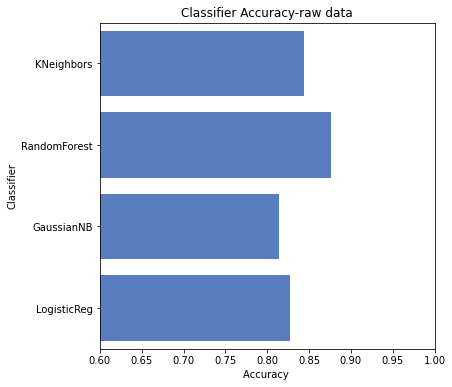

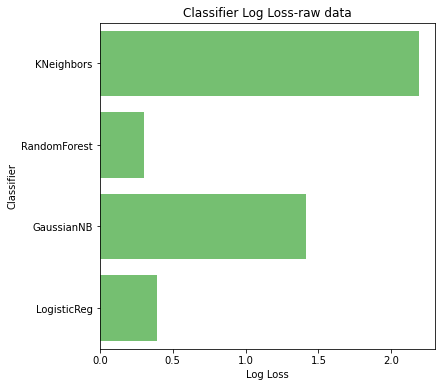

In [91]:
data_raw = log_df[log_df["Preprocessing"]== "raw data"]
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=data_raw, color="b")
plt.xlabel('Accuracy ')
plt.title('Classifier Accuracy-raw data')
plt.xlim(0.6,1)
plt.show()
sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=data_raw, color="g")
plt.xlabel('Log Loss')
plt.title('Classifier Log Loss-raw data')
plt.show()

______
Let us start with the raw data. In this case Random Forest showed the best accuracy and the lowest error. This is a good example of how the algorithm does not need pre-processing for making good predictions, is pretty accurate with raw data. It is flexible to both classification and regression problems. Also,  works well with both categorical and continuous values.

The k-nearest neighbours algorithm is one of the most widely used data mining models because of its simplicity and accurate results. However, when it comes to deal with
big datasets, with potentially noisy and missing information,
this technique becomes ineffective and inefficient. In this case, we can see that the higuer loss is obtained by the k-nearest.
______

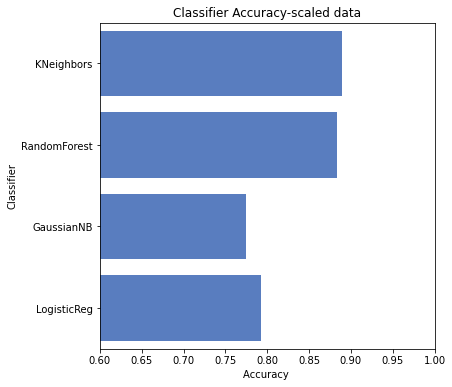

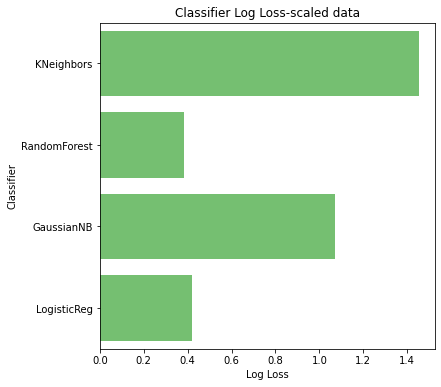

In [92]:
data_scaled = log_df[log_df["Preprocessing"]== "scaled"]
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=data_scaled, color="b")
plt.xlabel('Accuracy ')
plt.title('Classifier Accuracy-scaled data')
plt.xlim(0.6,1)
plt.show()
sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=data_scaled, color="g")
plt.xlabel('Log Loss')
plt.title('Classifier Log Loss-scaled data')
plt.show()

_____
Here the performance improved significantly for k-neighbors, however the lost did not improve. Logistic Regression does not improve with the scaled data. In logistic regression, we are only concerned about the probability of outcome dependent variable (success or failure). For the Gaussian NB the results does not improve after the optimization.

In this case we could say that the better result is still random forest. However, even with the good results we could say that the model does not achive a desired performance. We think that one of the reasons is beacuse the test dataset is not really big. It means that any error will decrease considerably the accuracy and increase the loss of the results.
____

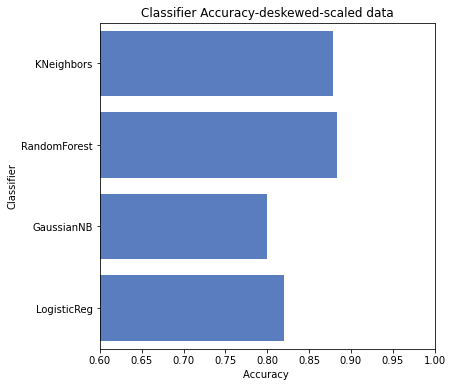

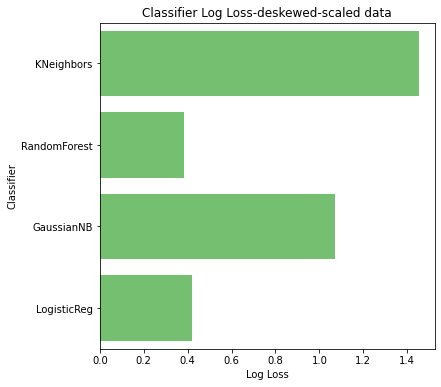

In [93]:
data_skewed_scaled = log_df[log_df["Preprocessing"]== "deskewed_scaled"]
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=data_skewed_scaled, color="b")
plt.xlabel('Accuracy ')
plt.title('Classifier Accuracy-deskewed-scaled data')
plt.xlim(0.6,1)
plt.show()
sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=data_skewed_scaled, color="g")
plt.xlabel('Log Loss')
plt.title('Classifier Log Loss-deskewed-scaled data')
plt.show()

The Deskewed Scaled process increase the accuracy as expected. This is because we are reducing the noisy parameters that does not allow the model to show the best performance and assign the wrong class to the input.

###**GridSearched**

____
The best accuracy is obtained with the GridSearched, we can see that KNeighbors and Random Forest imporved the result upper 0.86%. This shows how tunning of the hyperparameters can select the best class in the classification task. This is one of the most important procedures in order to get good results in the ML classification problem.
_____

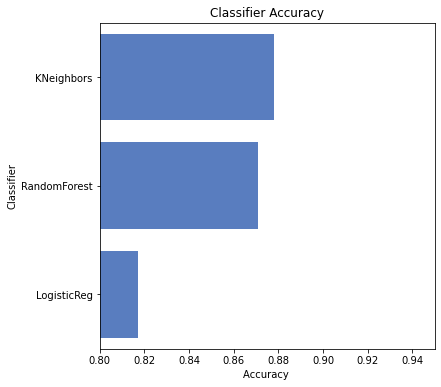

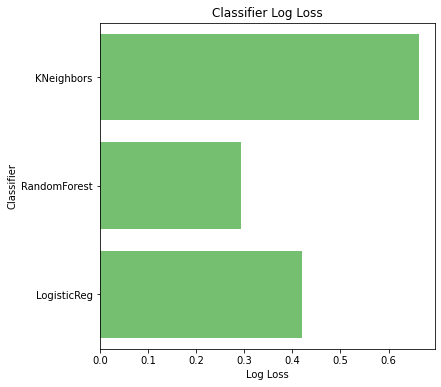

In [98]:
data_gridsearched = log_df[log_df["Preprocessing"]== "gridsearched"]
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=data_gridsearched, color="b")
plt.xlabel('Accuracy ')
plt.title('Classifier Accuracy')
plt.xlim(0.8,0.95)
plt.show()
sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=data_gridsearched, color="g")
plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

#**Conclusion Binary Classification**



*   The best performance was showed by the Deep Learning Algorithms as expected. Deep learning algorithms try to learn high-level features from data. This is a very distinctive part of Deep Learning and a major step ahead of traditional Machine Learning. Therefore, deep learning reduces the task of developing new feature extractor for every problem. In this case, we could implement other solutions, like data augmentation, or other convolutional neural networks. However, the time was not enought to implement this methods.

*   Feature extraction is a task that requires effort in order to have good results. The better the features are, the better results we can get. It defines the behavior of an image and show its place in terms of storage taken, efficiency in classification and time consumption.Feature extraction increases the accuracy of learned models by extracting features from the input data. This phase of the general framework reduces the dimensionality of data by removing the redundant data. 

*   The best classical method for this binary classification was Random Forest, this is already knowed as one of the best options for image classification because it reduces overfitting in decision trees and helps to improve the accuracy. It is flexible to both classification and regression problems and works well with both categorical and continuous values. RF automates missing values present in the data.



